In [1]:
with open("requirements.txt", "w") as f:
    f.write("kfp==1.8.9\n")
    
!pip install -r requirements.txt  --upgrade --user

     |████████████████████████████████| 296 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.7 MB 51.6 MB/s eta 0:00:01
  Created wheel for kfp: filename=kfp-1.8.9-py3-none-any.whl size=409653 sha256=afe5470f5e8cb91875632795b7223b2dfb6693fde7141338649ca4351bb09b16
  Stored in directory: /home/jovyan/.cache/pip/wheels/74/45/05/323f17840bbf9963e873b7a1e75caba3d5ab927c390c98c740
Successfully built kfp
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


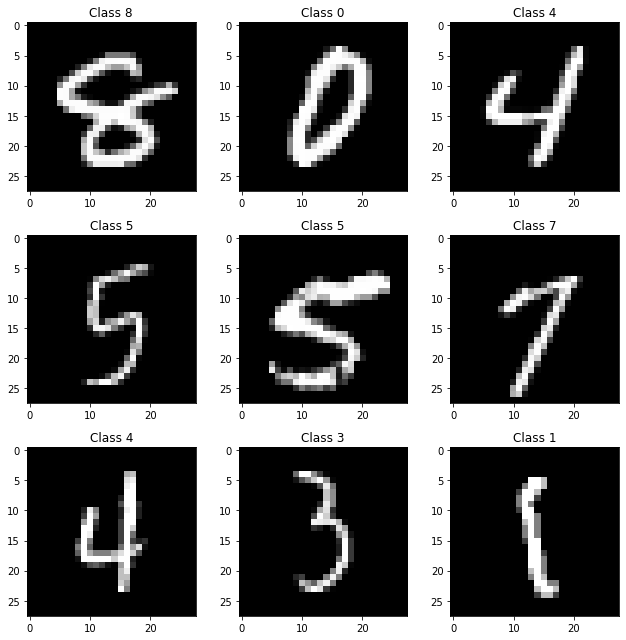

In [4]:
# ## uncomment the below code to visualize the x_train/y_train data

# import tensorflow as tf
# import json
# import matplotlib.pyplot as plt
# import random 
# mnist = tf.keras.datasets.mnist
# (x_train,y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train/255.0, x_test/255.0
    
# plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

# for i in range(9):
#     plt.subplot(3,3,i+1)
#     num = random.randint(0, len(x_train))
#     plt.imshow(x_train[num], cmap='gray', interpolation='none')
#     plt.title("Class {}".format(y_train[num]))
    
# plt.tight_layout()

In [11]:
from typing import NamedTuple

import kfp
from kfp import dsl
from kfp.components import func_to_container_op, InputPath, OutputPath

from typing import NamedTuple
def mnist_func(log_folder:str) -> NamedTuple('Outputs', [('logdir', str)]):
    
    print('mnist_func:', log_folder)
    import tensorflow as tf
    import json
    mnist = tf.keras.datasets.mnist
    (x_train,y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train/255.0, x_test/255.0

    def create_model():
        return tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape = (28,28)),
            tf.keras.layers.Dense(512, activation = 'relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation = 'softmax')
        ])
    model = create_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    import datetime
    import os
    
    ### add tensorboard logout callback
    log_dir = os.path.join(log_folder, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ######
    
    model.fit(x=x_train, 
              y=y_train, 
              epochs=5, 
              validation_data=(x_test, y_test), 
              callbacks=[tensorboard_callback])

    print('At least tensorboard callbacks are correct')
    print('logdir:', log_dir)
    return ([log_dir])

def tensorboard_func(log_dir:str) -> NamedTuple('Outputs', [('mlpipeline_ui_metadata', 'UI_metadata')]):
    
    print('tensorboard_func:', log_dir)
    # run this pipeline first and then apply hack/tensorboard-use-local-volume.yaml
    # to switch tensorboard to use local volume
    metadata = {
      'outputs' : [{
        'type': 'tensorboard',
        #'source': log_dir,
        'source': 'gs://footprintai-kubeflow-workshop/mnist/epoch5',
      }]
    }
    import json
    return ([json.dumps(metadata)])


In [12]:
import kfp.dsl as dsl
import kfp.components as components

@dsl.pipeline(
   name='mnist pipeline',
   description='A pipeline to train a model on mnist dataset and start a tensorboard.'
)
def mnist_pipeline():

    log_folder = '/persist-log'
    pvc_name = "mypvc"
    
    vop = dsl.VolumeOp(
        name=pvc_name,
        resource_name="newpvc",
        size="1Gi",
        modes=dsl.VOLUME_MODE_RWO
    )
    mnist_op = func_to_container_op(
        func=mnist_func,
        base_image="tensorflow/tensorflow:2.0.0-py3",
    )
    tensorboard_op = func_to_container_op(
        func=tensorboard_func,
        base_image="python:3.7-slim",
    )
    
    mnist_task = mnist_op(log_folder).add_pvolumes({
        log_folder:vop.volume,
    })
    tenaorboard_task = tensorboard_op(mnist_task.outputs['logdir']).add_pvolumes({
        log_folder:vop.volume,
    })


In [13]:
kfp.compiler.Compiler().compile(mnist_pipeline, 'helloworld.zip')